In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sipm.util.functions as func
import pandas as pd
import glob
import scipy
from scipy.interpolate import interp1d
import csv
import os
from sipm.analysis.SipmCalibration import SipmCalibration
import yaml

In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
!pwd


/home/as111/sipm-analysis


In [5]:
# data folder
path = "/scratch/gpfs/as111/results/2023-08-14/"
data_fft = {}
channels = [0, 1, 2, 3]
voltages = [90, 92, 94, 96, 98]
for ch in channels:
    data_fft[ch] = {}
    for volt in voltages:
        data_fft[ch][volt] = {
            'frequency_MHz':np.zeros(0),
            'n_0pe_wfs':0,
            'avg_0pe_psd':np.zeros(0),
            'n_1pe_wfs':0,
            'avg_1pe_psd':np.zeros(0)}
        files = glob.glob(f"{path}/*volt_{volt}*fft.h5")
        for f in files:
            df = pd.read_hdf(f, key=f'{volt}/{ch}')
            if data_fft[ch][volt]['frequency_MHz'].shape[0]==0:
                data_fft[ch][volt]['frequency_MHz'] = np.array(df['frequency_MHz'])
            data_fft[ch][volt]['n_0pe_wfs'] += np.array(df['n_0pe_wfs'])[0]
            if data_fft[ch][volt]['avg_0pe_psd'].shape[0]==0:
                data_fft[ch][volt]['avg_0pe_psd'] = np.array(df['avg_0pe_psd'])*np.array(df['n_0pe_wfs'])[0]
            else:
                data_fft[ch][volt]['avg_0pe_psd'] += np.array(df['avg_0pe_psd'])*np.array(df['n_0pe_wfs'])[0]
            data_fft[ch][volt]['n_1pe_wfs'] += np.array(df['n_1pe_wfs'])[0]
            if data_fft[ch][volt]['avg_1pe_psd'].shape[0]==0:
                data_fft[ch][volt]['avg_1pe_psd'] = np.array(df['avg_1pe_psd'])*np.array(df['n_1pe_wfs'])[0]
            else:
                data_fft[ch][volt]['avg_1pe_psd'] += np.array(df['avg_1pe_psd'])*np.array(df['n_1pe_wfs'])[0]
        df = None
        data_fft[ch][volt]['avg_0pe_psd'] /= data_fft[ch][volt]['n_0pe_wfs']
        data_fft[ch][volt]['avg_1pe_psd'] /= data_fft[ch][volt]['n_1pe_wfs']

ch0 90V 0pe:21599 events 1pe:46411 events
ch0 92V 0pe:16287 events 1pe:36601 events
ch0 94V 0pe:14126 events 1pe:31232 events
ch0 96V 0pe:12727 events 1pe:26553 events
ch0 98V 0pe:11766 events 1pe:22896 events
ch1 90V 0pe:16570 events 1pe:38547 events
ch1 92V 0pe:13268 events 1pe:31379 events
ch1 94V 0pe:11922 events 1pe:26907 events
ch1 96V 0pe:10897 events 1pe:23262 events
ch1 98V 0pe:10254 events 1pe:19888 events
ch2 90V 0pe:14822 events 1pe:37559 events
ch2 92V 0pe:10721 events 1pe:28222 events
ch2 94V 0pe:9054 events 1pe:23264 events
ch2 96V 0pe:8138 events 1pe:19758 events
ch2 98V 0pe:7492 events 1pe:16903 events
ch3 90V 0pe:10878 events 1pe:29968 events
ch3 92V 0pe:8672 events 1pe:23568 events
ch3 94V 0pe:7487 events 1pe:20191 events
ch3 96V 0pe:6880 events 1pe:17110 events
ch3 98V 0pe:6317 events 1pe:14746 events


Text(0.07, 0.5, 'Power Spectral Density (A.U.)')

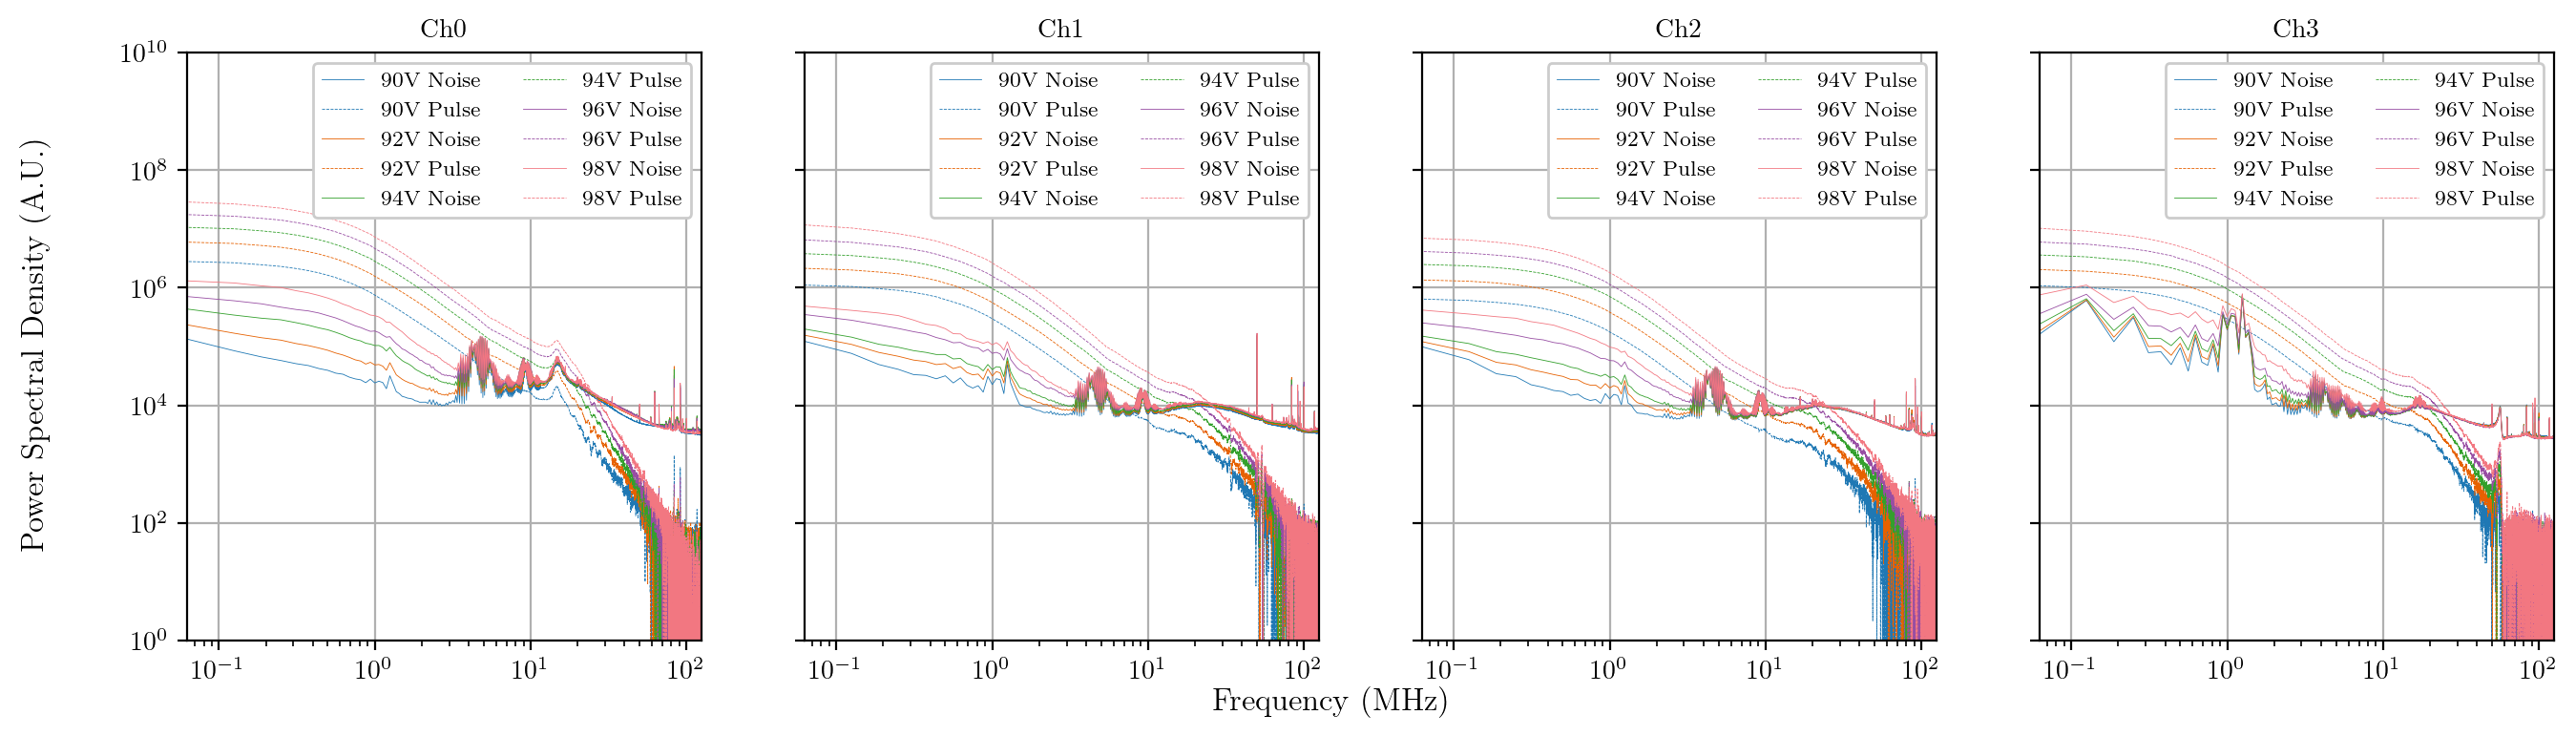

In [13]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(16, 4)
for j, ch in enumerate(channels):
    for k, volt in enumerate(voltages):
        print(f'ch{ch} {volt}V 0pe:{data_fft[ch][volt]["n_0pe_wfs"]:.0f} events 1pe:{data_fft[ch][volt]["n_1pe_wfs"]:.0f} events')
        axs[j].plot(
            data_fft[ch][volt]['frequency_MHz'],
            data_fft[ch][volt]['avg_0pe_psd'],
            label=f'{volt}V Noise', color=f'C{k}', linewidth=0.3, linestyle='-')
        axs[j].plot(
            data_fft[ch][volt]['frequency_MHz'],
            data_fft[ch][volt]['avg_1pe_psd']-data_fft[ch][volt]['avg_0pe_psd'],
            label=f'{volt}V Pulse', color=f'C{k}', linewidth=0.3, linestyle='--')
    axs[j].legend(loc='upper right', ncol=2, fontsize=8)
    axs[j].set_xlim(1./16, 125)
    axs[j].set_ylim(1e0, 1e10)
    axs[j].set_yscale('log')
    axs[j].set_xscale('log')
    axs[j].minorticks_on()
    axs[j].grid()
    axs[j].set_title(f'Ch{ch}')
fig.supxlabel(r'Frequency (MHz)', y=0.01)
fig.supylabel(r'Power Spectral Density (A.U.)', x=0.07)

# Wiener deconvolution filter
The Wiener deconvolution filter is given by
$$G_{w}(f)=\frac{H(f)^\ast S(f)}{|H(f)|^2 S(f) + N(f)},$$
where $H(f)$ is the response function, $N(f)$ is the noise power spectrum, and $S(f)$ is the original signal power spectrum. We assume $S(f)=1$ fow now. The Wiener filter minimizes the sum of square errors between the original signal (unconvoluted by the SiPM response, that is, the photon arrival time distribution) and the filtered signal.

Text(0.07, 0.5, 'Wiener factor $|H|^2/(|H|^2+N)$')

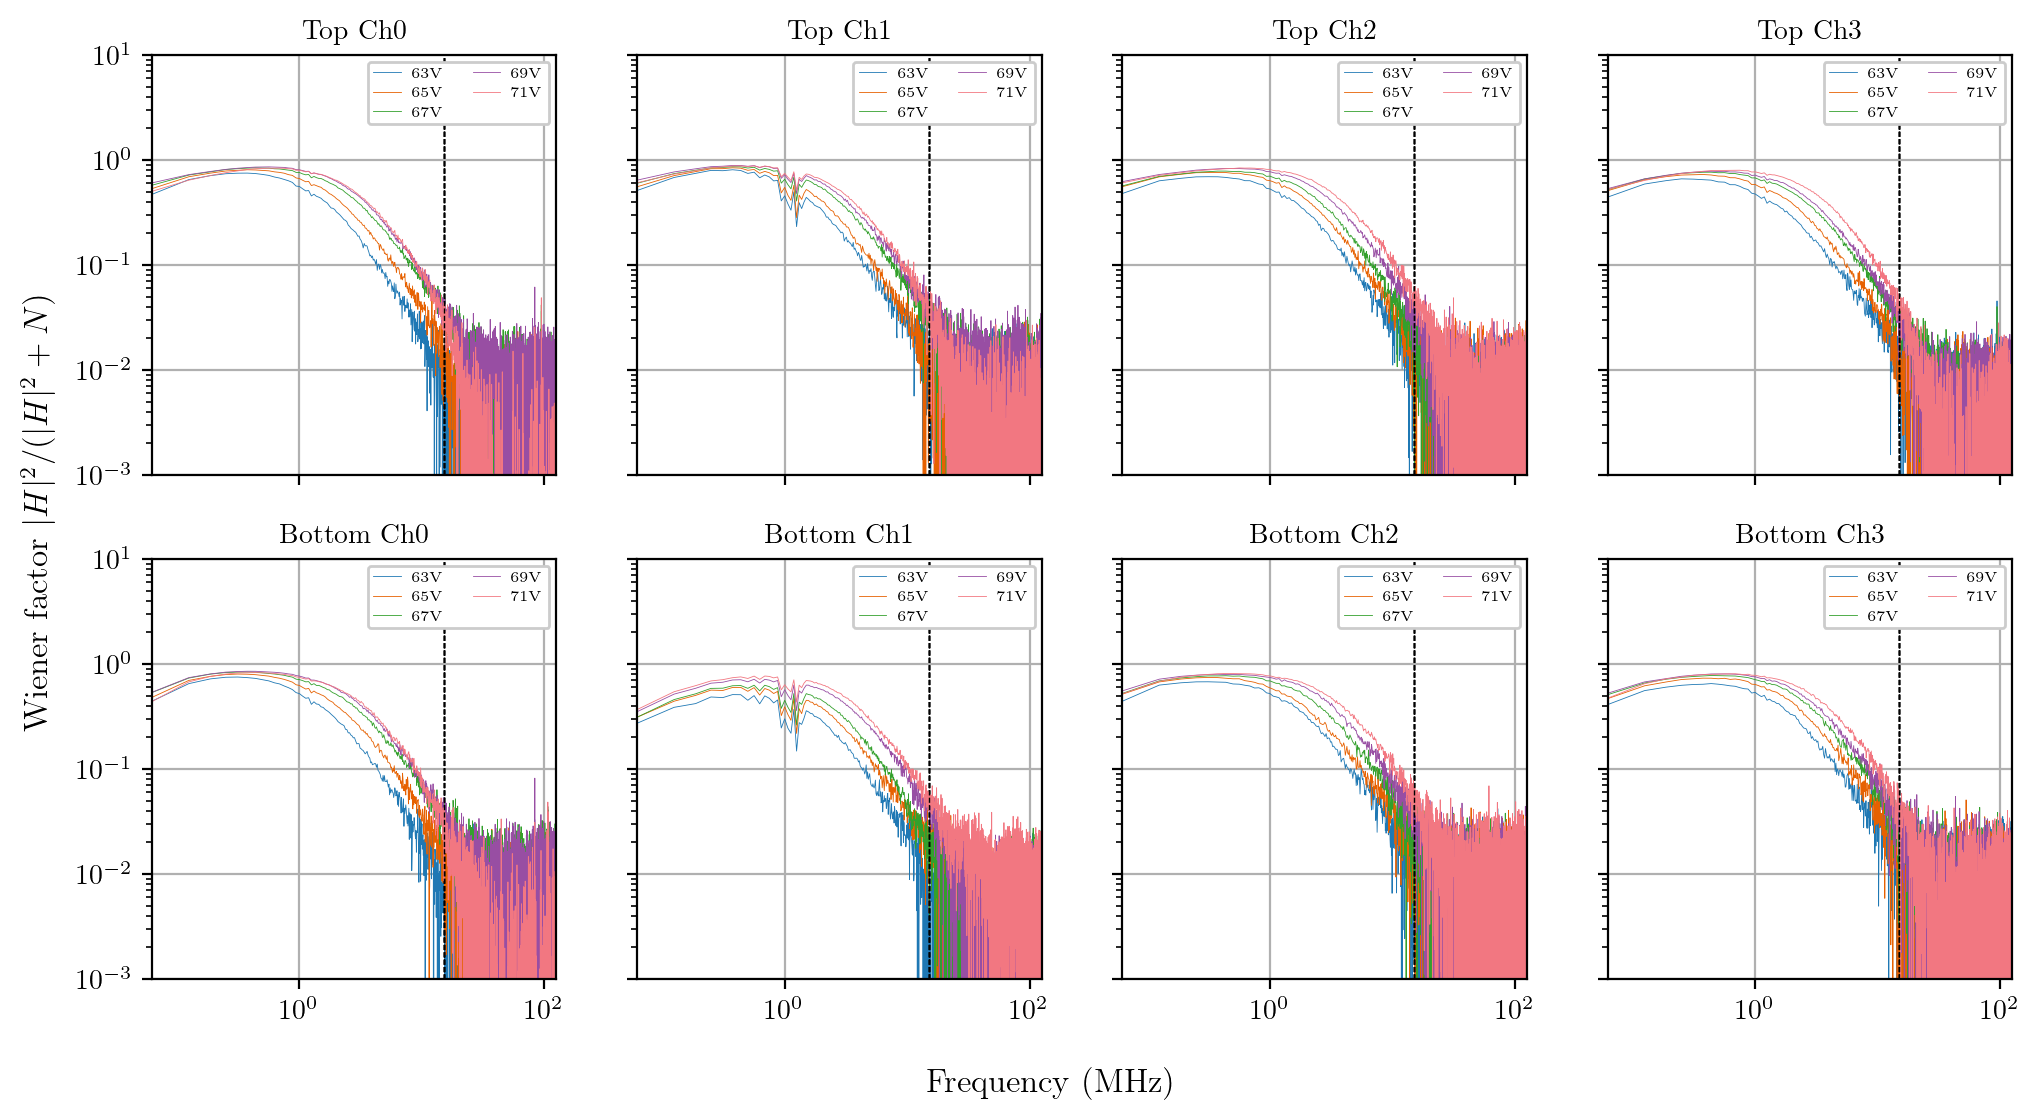

In [8]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
yrange=(1e-3,1e1)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            data_fft[pos][ch][volt]['wiener_factor'] = 1-data_fft[pos][ch][volt]['avg_0pe_psd']/data_fft[pos][ch][volt]['avg_1pe_psd']
            axs[i, j].plot(
                data_fft[pos][ch][volt]['frequency_MHz'],
                data_fft[pos][ch][volt]['wiener_factor'],
                label=f'{volt}V', color=f'C{k}', linewidth=0.3, linestyle='-')
            cutoff_MHz = 15
            axs[i, j].plot([cutoff_MHz]*2, yrange, 'k--', linewidth=0.5)
            data_fft[pos][ch][volt]['wiener_factor'][ (data_fft[pos][ch][volt]['frequency_MHz']>cutoff_MHz) & ((data_fft[pos][ch][volt]['frequency_MHz']<data_fft[pos][ch][volt]['frequency_MHz'][-1]+data_fft[pos][ch][volt]['frequency_MHz'][1]-cutoff_MHz)) ] = 0
        axs[i, j].legend(loc='upper right', ncol=2, fontsize=5)
        axs[i, j].set_xlim(1./16, 125)
        axs[i, j].set_ylim(yrange[0], yrange[1])
        axs[i, j].set_yscale('log')
        axs[i, j].set_xscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Frequency (MHz)', y=0.01)
fig.supylabel(r'Wiener factor $|H|^2/(|H|^2+N)$', x=0.07)

# FFT on the averaged waveform
This is to estimate $H(f)$ including the phase.

Text(0.07, 0.5, 'FFT Abs. Amplitude (ADC Unit)')

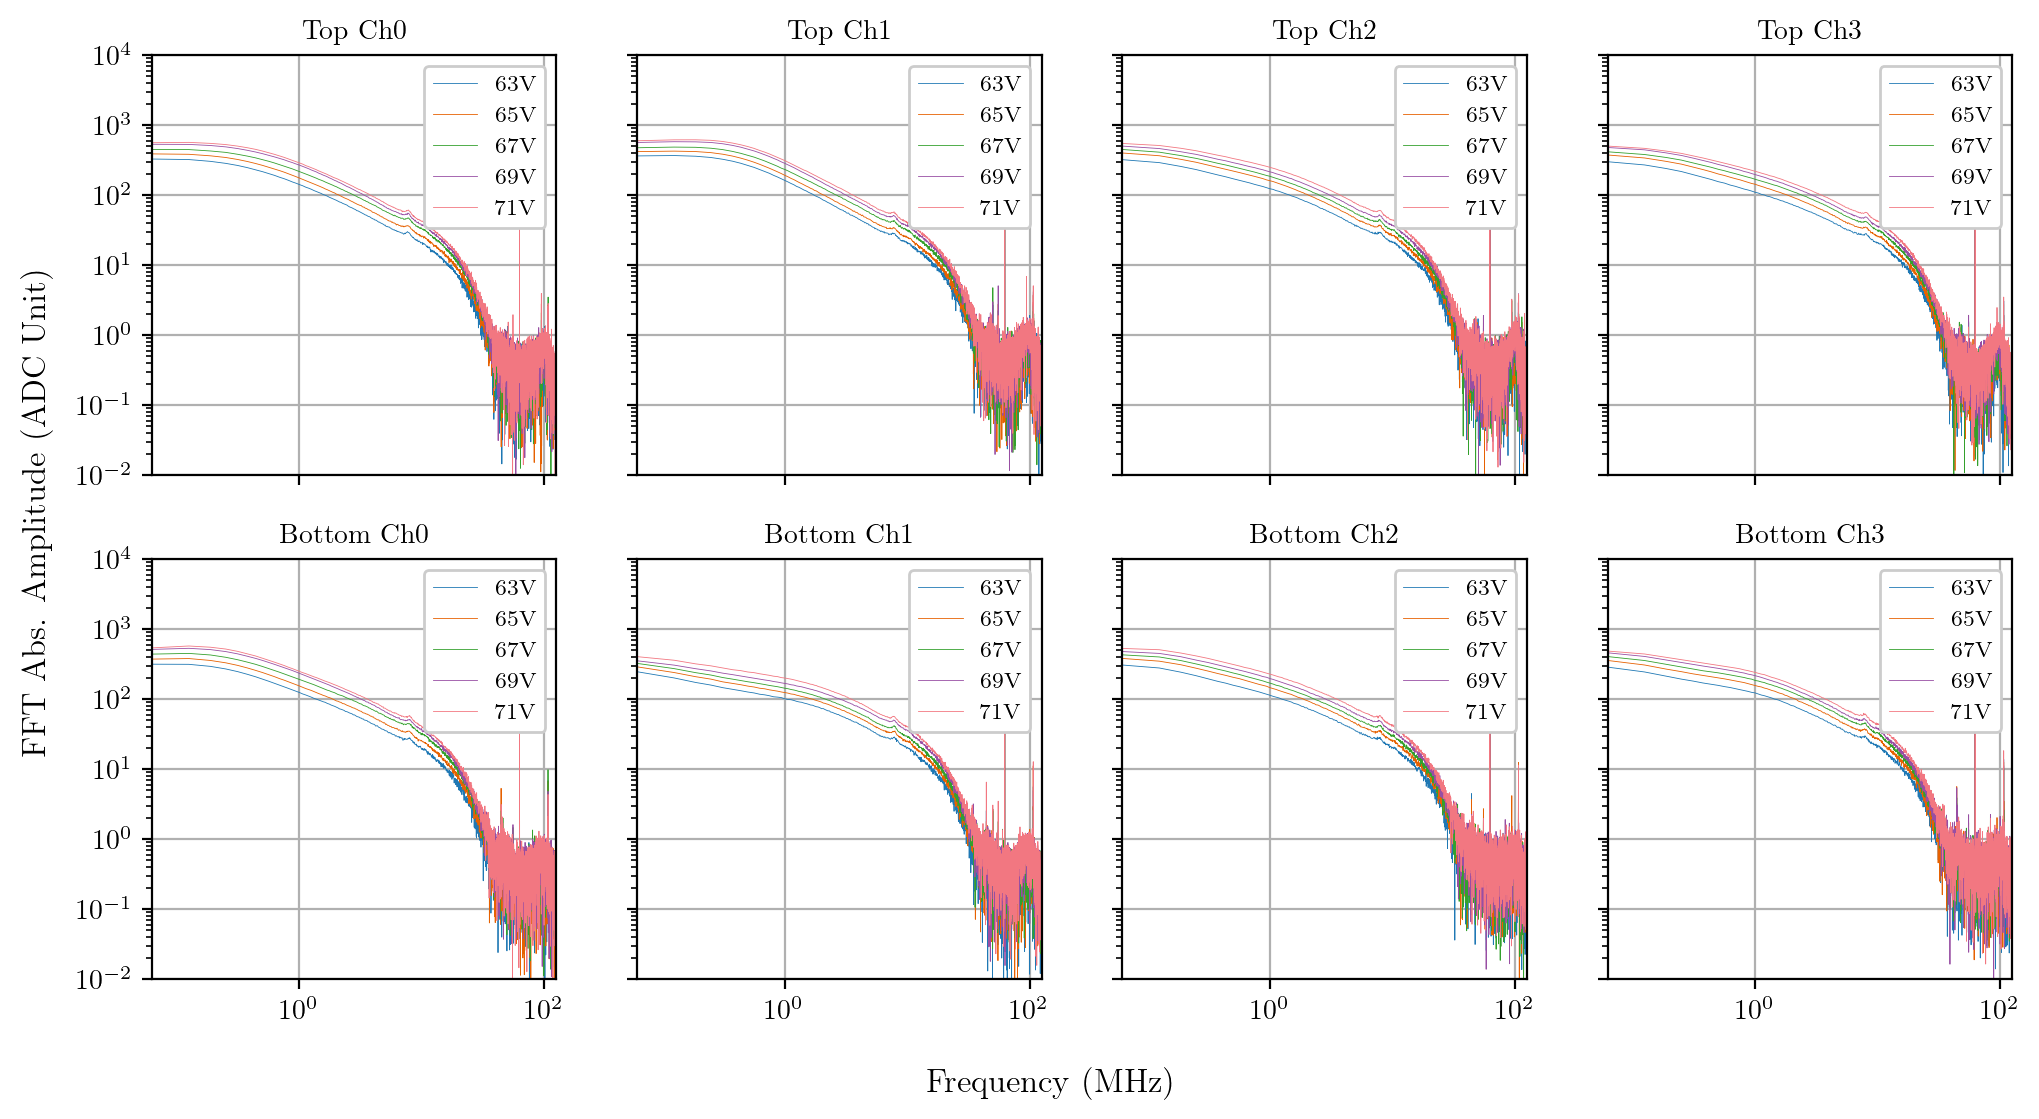

In [9]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            data_spe[pos][ch][volt]['fft_spe_wf'] = scipy.fft.fft(data_spe[pos][ch][volt]['avg_spe_wf'])
            dt = data_spe[pos][ch][volt]['time'][1]-data_spe[pos][ch][volt]['time'][0]
            t_total = dt+data_spe[pos][ch][volt]['time'][-1]
            n_over_2 = int(data_spe[pos][ch][volt]['time'].shape[0]/2)
            data_spe[pos][ch][volt]['frequency'] = data_spe[pos][ch][volt]['time']/dt/t_total
            axs[i, j].plot(
                data_spe[pos][ch][volt]['frequency'][:n_over_2],
                abs(data_spe[pos][ch][volt]['fft_spe_wf'][:n_over_2]),
                label=f'{volt}V', color=f'C{k}', linewidth=0.3)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlim(data_spe[pos][ch][volt]['frequency'][1], data_spe[pos][ch][volt]['frequency'][n_over_2])
        # axs[i, j].set_xlim(0,5)
        axs[i, j].set_ylim(1e-2, 1e4)
        axs[i, j].set_xscale('log')
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Frequency (MHz)', y=0.01)
fig.supylabel(r'FFT Abs. Amplitude (ADC Unit)', x=0.07)

# Compute Wiener filter and save as .h5

In [10]:
# Compute Wiener filter
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            dt = data_spe[pos][ch][volt]['time'][1]-data_spe[pos][ch][volt]['time'][0]
            shift = np.array([np.exp(complex(0,-2*np.pi*freq*dt*int(np.argmax(data_spe[pos][ch][volt]['avg_spe_wf'])))) for freq in data_spe[pos][ch][volt]['frequency']])
            data_fft[pos][ch][volt]['wiener_filter'] = shift*np.conjugate(data_spe[pos][ch][volt]['fft_spe_wf'])/data_fft[pos][ch][volt]['avg_1pe_psd']

In [11]:
h5filename = 'data/deconvolution_liq2.h5'
for pos in positions:
    for ch in channels:
        for volt in voltages:
            store = pd.HDFStore(h5filename)
            store.put(f'{pos}/ch{ch}/{volt}V',pd.DataFrame.from_dict(data_fft[pos][ch][volt]))
            store.close()

/home/as111/miniconda3/envs/sipm/lib/python3.8/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '63V'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/as111/miniconda3/envs/sipm/lib/python3.8/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '65V'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/as111/miniconda3/envs/sipm/lib/python3.8/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '67V'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getatt

# Read from .h5

/home/as111/miniconda3/envs/sipm/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


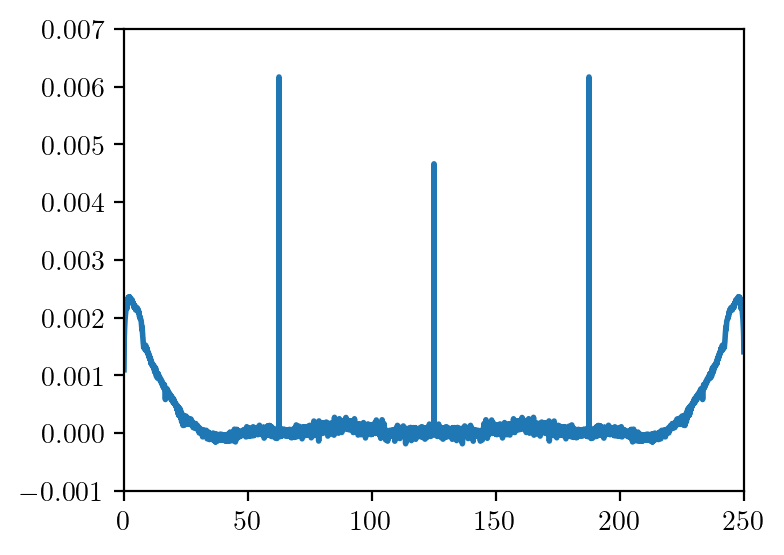

In [12]:
filter_h5 = pd.HDFStore(h5filename)
plt.plot(np.array(filter_h5['/top/ch0/67V']['frequency_MHz']), np.array(filter_h5['/top/ch0/67V']['wiener_filter']))

# Matched filter
The matched filter maximizes the signal-to-noise ratio. It is given by
$$G_{m}(f)=\frac{H(f)^\ast}{N(f)}.$$

In [13]:
# Compute matched filter
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            dt = data_spe[pos][ch][volt]['time'][1]-data_spe[pos][ch][volt]['time'][0]
            shift = np.array([np.exp(complex(0,-2*np.pi*freq*dt*int(np.argmax(data_spe[pos][ch][volt]['avg_spe_wf'])))) for freq in data_spe[pos][ch][volt]['frequency']])
            data_fft[pos][ch][volt]['matched_filter'] = shift*np.conjugate(data_spe[pos][ch][volt]['fft_spe_wf'])/data_fft[pos][ch][volt]['avg_0pe_psd']

/home/as111/miniconda3/envs/sipm/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


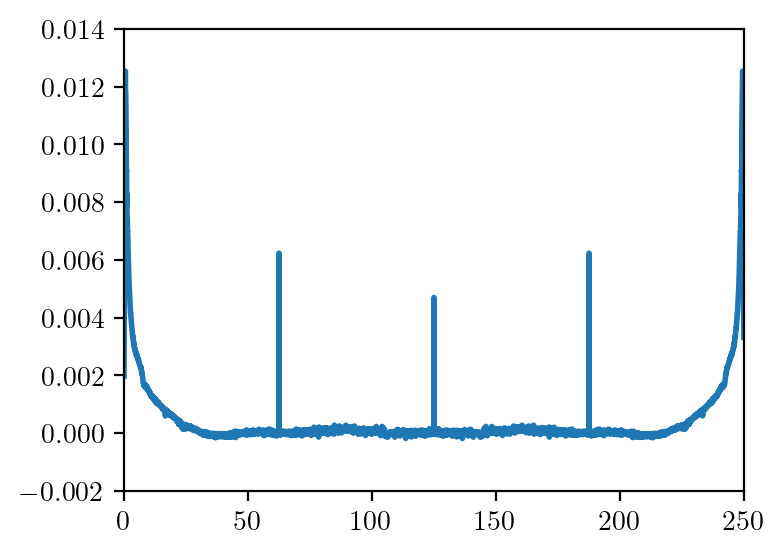

In [14]:
plt.plot(np.array(filter_h5['/top/ch0/67V']['frequency_MHz']), np.array(data_fft['top'][0][67]['matched_filter']))

# Try some laser/scintillation waveforms

No time.txt file
/scratch/gpfs/GALBIATI/data/sipm//reflector_studies/2022-11-22/2022-11-22_volt_67_pos_bottom_light_laser_coinc_laser_cond_calibration/0/wave3.dat
10989 events


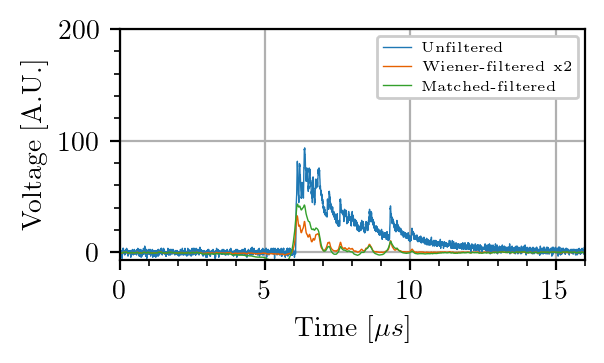

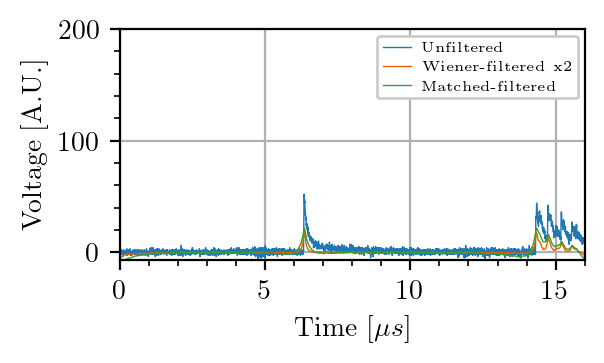

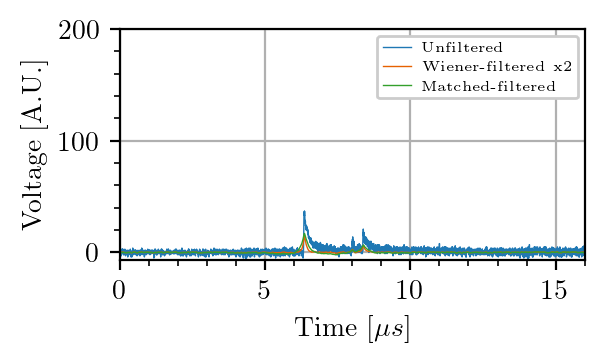

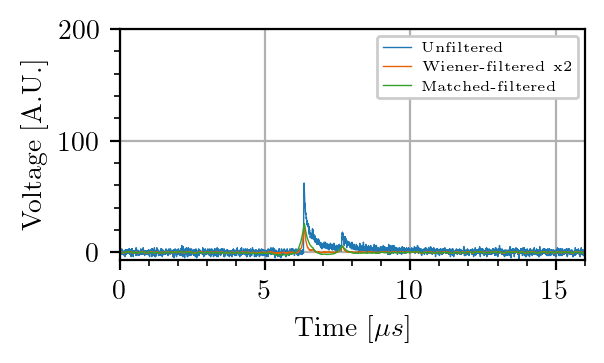

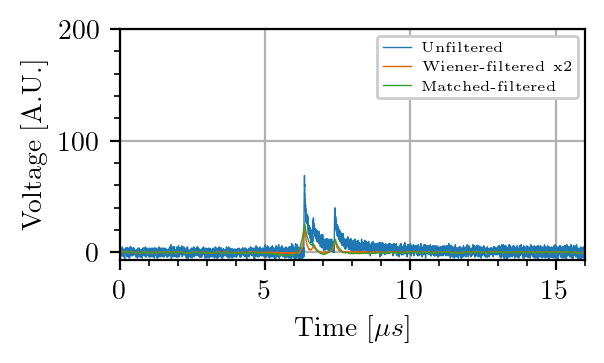

In [15]:
import sipm.recon.WaveformDataset as wfd
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/'
# direc = '2022-11-20/2022-11-20_volt_67_pos_bottom_light_scintillation_coinc_000_cond_gamma/0/' # scintillation
direc = '2022-11-22/2022-11-22_volt_67_pos_bottom_light_laser_coinc_laser_cond_calibration/0/' # laser
ch = 3
volt = 67
pos = 'bottom'
evid = np.arange(0, 500)
dset = wfd.WaveformDataset(path='{}{}'.format(data_dir, direc), pol=-1, channels=range(4), samples=4000)
wfs, _ = dset.ch[ch].get_waveforms(ev=evid, ar_filter=False)

for i, wf in enumerate(wfs):
    wiener = np.sqrt(len(wf))*scipy.fft.ifft(scipy.fft.fft(np.array(wf))*data_fft[pos][ch][volt]['wiener_filter']).real
    # dt = data_spe[pos][ch][volt]['time'][1]-data_spe[pos][ch][volt]['time'][0]
    # shift = np.array([np.exp(complex(0,-2*np.pi*freq*dt*int(np.argmax(data_spe[pos][ch][volt]['avg_spe_wf'])))) for freq in data_spe[pos][ch][volt]['frequency']])
    # cutoff_MHz = 15
    # cutoff = (data_fft[pos][ch][volt]['frequency_MHz']<cutoff_MHz) | ((data_fft[pos][ch][volt]['frequency_MHz']>data_fft[pos][ch][volt]['frequency_MHz'][-1]+data_fft[pos][ch][volt]['frequency_MHz'][1]-cutoff_MHz))
    # simple_deconv = np.sqrt(len(wf))*scipy.fft.ifft(scipy.fft.fft(np.array(wf))*shift/data_spe[pos][ch][volt]['fft_spe_wf']*cutoff).real
    matched = np.sqrt(len(wf))*scipy.fft.ifft(scipy.fft.fft(np.array(wf))*data_fft[pos][ch][volt]['matched_filter']).real
    if np.amax(wiener[dset.ch[ch].time>7.0]>2):
        plt.figure(i, figsize=(3, 1.5))
        plt.plot(dset.ch[ch].time, wf, label='Unfiltered', linewidth=0.5)
        plt.plot(dset.ch[ch].time, wiener*2, label='Wiener-filtered x2', linewidth=0.5)
        plt.plot(dset.ch[ch].time, matched, label='Matched-filtered', linewidth=0.5)
        # plt.plot(dset.ch[ch].time, simple_deconv, label='Simple+cut-off', linewidth=0.5)
        plt.legend(loc='upper right', fontsize=5)
        plt.xlabel(r'Time [$\mu s$]')
        plt.ylabel(r'Voltage [A.U.]')
        plt.minorticks_on()
        plt.grid()
        plt.xlim(0, 16)
        plt.ylim(-7, 200)